# Plots

In [ ]:
# working on plots because i don't have gpus right now

import numpy as np
import seaborn as sns
import pandas as pd 
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
numpy.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# SEED i: Treatment j 
colors = ['#FF8C00','#1e90ff','#708090']
order = ['DA','CEVAE','M3E2']
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [ ]:
dataname = 'gwas'
path = '/content/output/'
listfile = pd.read_csv(path+'listfile_exp_'+dataname+'.csv',sep=',',index_col=None)
listfile

,config,sample_size,treatments,confounders
0,config1a,2500,5,995
1,config1b,5000,5,995
2,config1c,10000,5,995
3,config1d,10000,1,1000
4,config1e,10000,3,1000
5,config1f,10000,6,1000
6,config1g,10000,9,1000
7,config1h,10000,12,1000
8,config1i,10000,5,100
9,config1j,10000,5,500


In [ ]:
#picking config c as the individual plot results 
data = pd.read_csv(path+'output_'+dataname+'_config1c.csv').iloc[:, 1:]
data['type'] = 'Baselines'
data['type'][data['Method']=='M3E2'] = 'Proposed'
data.drop(['seed_models'],axis=1, inplace=True)
print(data.head())

TrueEffect = data[data['Method']=='TrueTreat']
TrueEffect.drop_duplicates(keep='first', inplace=True)
print(TrueEffect)

data = data[data['Method']!='TrueTreat']

      Method       MAE   F1_Test  ...        T4  seed_data       type
0         DA  0.449178  0.170599  ...  0.151091          8  Baselines
1      CEVAE  0.552312  0.455607  ...  0.149497          8  Baselines
2       M3E2  0.498621  0.594848  ...  0.219447          8   Proposed
3  TrueTreat  0.000000  0.000000  ... -0.574123          8  Baselines
4         DA  0.439725  0.093891  ...  0.174318          8  Baselines

[5 rows x 11 columns]
      Method  MAE  F1_Test  Time(s)  ...        T3        T4  seed_data       type
3  TrueTreat  0.0      0.0      0.0  ... -0.346587 -0.574123          8  Baselines

[1 rows x 11 columns]


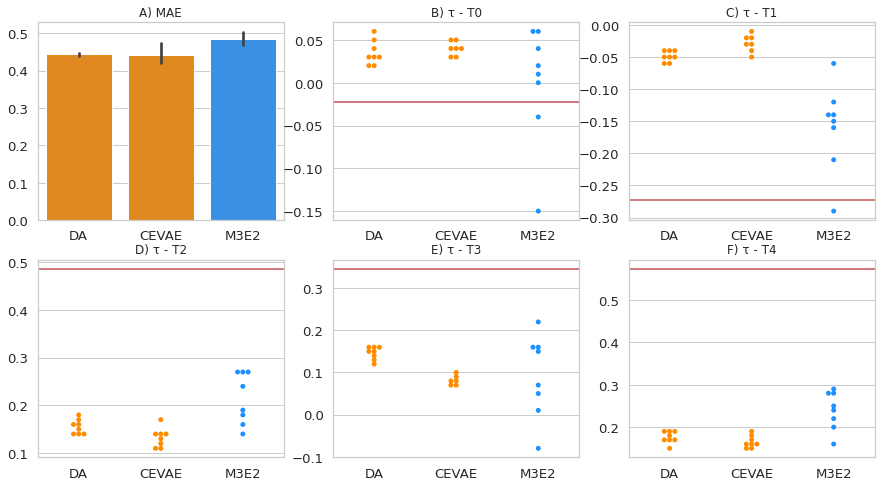

In [ ]:
def plot_treat(data, TrueEffect, ax_, seed,treat, colors, order, title):
  data_ = data[data['seed_data']==seed]
  data_ = data_.set_index('Method').loc[order]
  data_.reset_index(drop=False, inplace=True)
  true = TrueEffect[TrueEffect['seed_data']==seed][treat].values[0]*(-1)
  data_[treat] = data_[treat].round(2)
  sns.swarmplot(x="Method", y=treat,
                hue='type', 
                data=data_, 
                palette=sns.color_palette(colors),
                ax=ax_)
  ax_.set_xticklabels(ax_.get_xticklabels())#rotation=90
  ax_.legend([],[], frameon=False)
  ax_.axhline(y=true, color='r', linestyle='-')
  ax_.set_title(title+' τ - '+treat,fontsize=12)
  ax_.set(xlabel='', ylabel='')



fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(ncols=3, nrows=2, figsize = [15,8]) #)

seed = 8
plot_treat(data, TrueEffect, ax1, seed,'T0', colors,order, 'B)')
plot_treat(data, TrueEffect, ax2, seed,'T1', colors,order, 'C)')
plot_treat(data, TrueEffect, ax3, seed,'T2', colors,order, 'D)')
plot_treat(data, TrueEffect, ax4, seed,'T3', colors,order, 'E)')
plot_treat(data, TrueEffect, ax5, seed,'T4', colors,order, 'F)')

#Last Plot
data_ = data[data['seed_data']==seed]
sns.barplot(ax=ax0, x=data_['Method'], y=data_['MAE'],palette=sns.color_palette(colors), hue=data_['type'],dodge=False)
ax0.set(xlabel='', ylabel='')
ax0.set_title('A) MAE',fontsize=12)
ax0.legend([],[], frameon=False)
#plt.savefig('run_seed5_gwas.png', dpi=300, bbox_inches='tight')

In [ ]:
#LOADING ALL FILES IN ONE DB for GWAS

dataname = 'gwas'
#data = pd.read_csv(path+'output_'+dataname+'_config1c.csv').iloc[:, 1:]
listfile = pd.read_csv(path+'listfile_exp_'+dataname+'.csv',sep=',',index_col=None)

for i,config in enumerate(listfile['config'].values): 
  if config == 'config1a':
    bd_gwas = pd.read_csv(path+'output_'+dataname+'_'+config+'.csv').iloc[:, 1:]
    bd_gwas['config'] =  listfile['config'][i]
    bd_gwas['sample_size'] = listfile['sample_size'][i]
    bd_gwas['treatments'] = listfile['treatments'][i]
    bd_gwas['confounders'] = listfile['confounders'][i]
  else: 
    bd_gwas_aux = pd.read_csv(path+'output_'+dataname+'_'+config+'.csv').iloc[:, 1:]
    bd_gwas_aux['config'] =  listfile['config'][i]
    bd_gwas_aux['sample_size'] = listfile['sample_size'][i]
    bd_gwas_aux['treatments'] = listfile['treatments'][i]
    bd_gwas_aux['confounders'] = listfile['confounders'][i]
    bd_gwas = pd.concat([bd_gwas,bd_gwas_aux],axis=0)
bd_gwas.reset_index(drop=True,inplace=True)
bd_gwas['type'] = 'baseline'
bd_gwas['type'][bd_gwas['Method']=='M3E2'] = 'proposed'
bd_gwas=bd_gwas[bd_gwas['Method']!='TrueTreat']
bd_gwas.reset_index(drop=True,inplace=True)

bd_gwas['sample_size'] = bd_gwas['sample_size'].astype(str)
bd_gwas['treatments'] = bd_gwas['treatments'].astype(str)
bd_gwas['confounders'] = bd_gwas['confounders'].astype(str)


In [ ]:
#COPY CODE ABOVE
bd_copula = bd_gwas.copy()


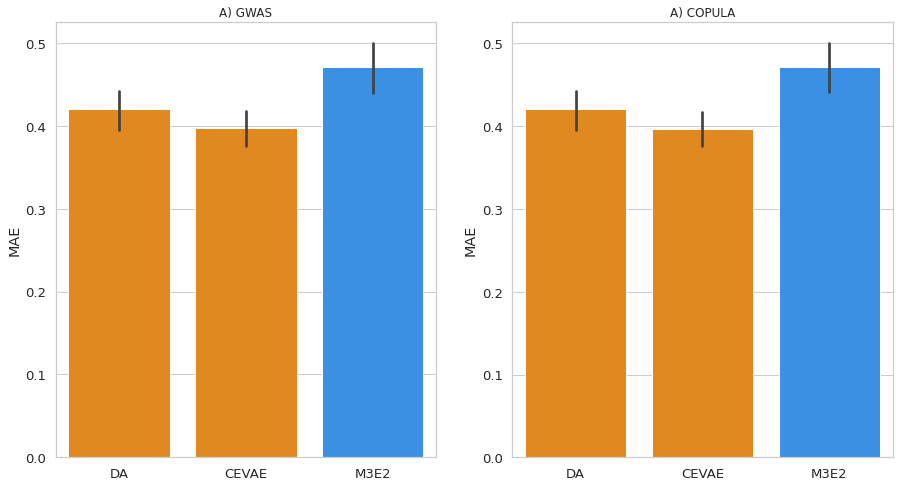

In [ ]:
#Overall
colors = ['#FF8C00','#1e90ff','#708090']
order = ['DA','CEVAE','M3E2']
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

fig, ((ax0,ax1)) = plt.subplots(ncols=2, nrows=1, figsize = [15,8]) #)

#GWAS
sns.barplot(ax=ax0, x=bd_gwas['Method'], y=bd_gwas['MAE'],palette=sns.color_palette(colors), hue=bd_gwas['type'],dodge=False)
ax0.set(xlabel='', ylabel='MAE')
ax0.set_title('A) GWAS',fontsize=12)
ax0.legend([],[], frameon=False)

#COPULA
sns.barplot(ax=ax1, x=bd_copula['Method'], y=bd_copula['MAE'],palette=sns.color_palette(colors), hue=bd_copula['type'],dodge=False)
ax1.set(xlabel='', ylabel='MAE')
ax1.set_title('A) COPULA',fontsize=12)
ax1.legend([],[], frameon=False)
plt.savefig('mae_average.png', dpi=300, bbox_inches='tight')

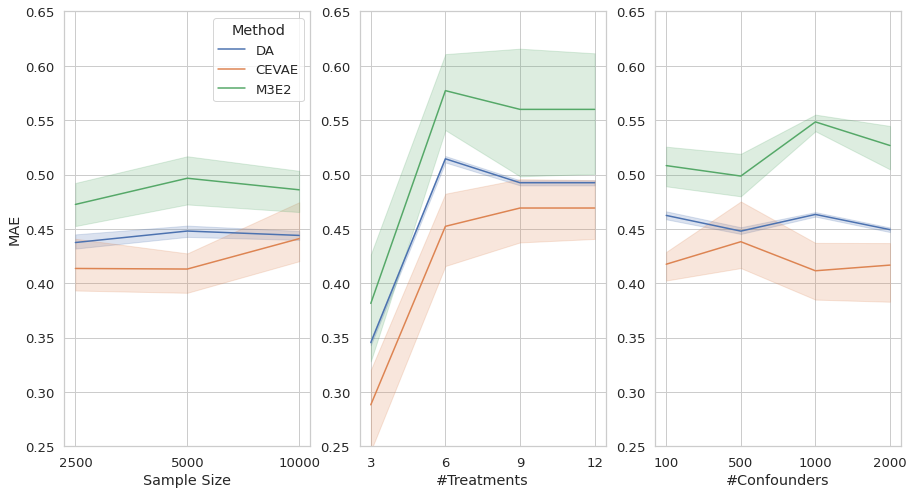

In [ ]:
#plot line 
fig, ((ax0,ax1,ax2)) = plt.subplots(ncols=3, nrows=1, figsize = [15,8]) #)
ymin, ymax = 0.25, 0.65

mysamplesize = ['config1a','config1b','config1c']
bd_gwas_n = bd_gwas[bd_gwas['config'].isin(mysamplesize)]
sns.lineplot(data=bd_gwas_n, x="sample_size", y="MAE",ax=ax0,hue='Method')
ax0.axis(ymin=ymin,ymax=ymax)
ax0.set(xlabel='Sample Size')

mysamplesize = ['config1e','config1f','config1g','config1h']
bd_gwas_t = bd_gwas[bd_gwas['config'].isin(mysamplesize)]
sns.lineplot(data=bd_gwas_t, x="treatments", y="MAE",ax=ax1,hue='Method')
ax1.axis(ymin=ymin,ymax=ymax)
ax1.set(xlabel='#Treatments',ylabel='')
ax1.legend([],[], frameon=False)

mysamplesize = ['config1i','config1j','config1k','config1l']
bd_gwas_c = bd_gwas[bd_gwas['config'].isin(mysamplesize)]
sns.lineplot(data=bd_gwas_c, x="confounders", y="MAE",ax=ax2,hue='Method')
ax2.axis(ymin=ymin,ymax=ymax)
ax2.set(xlabel='#Confounders',ylabel='')
ax2.legend([],[], frameon=False)